This notebook will create a preliminary dataset with features like records, fight details and fighter details. Then run a lasso reggression to determine the significant variables.

In [59]:
import pandas as pd
df = pd.read_csv('/Users/cstone/Documents/School/MGMT 6203/Project/raw/ufc_fight_results_date.txt')
df.columns

Index(['event', 'outcome', 'weightclass', 'method', 'round', 'time',
       'fight_id', 'fighter1', 'fighter2', 'date'],
      dtype='object')

In [60]:
df.head()

,event,outcome,weightclass,method,round,time,fight_id,fighter1,fighter2,date
0,UFC Fight Night: Dolidze vs. Imavov,0.0,mw,dec_maj,5,300,767ceb4a0cb43ade,Roman Dolidze,Nassourdine Imavov,2024-02-03
1,UFC Fight Night: Dolidze vs. Imavov,1.0,lw,dec_una,3,300,733e675fd7c0052a,Renato Moicano,Drew Dober,2024-02-03
2,UFC Fight Night: Dolidze vs. Imavov,1.0,ww,ko_tko,1,197,af6d56860ba4d259,Randy Brown,Muslim Salikhov,2024-02-03
3,UFC Fight Night: Dolidze vs. Imavov,0.0,wflw,dec_una,3,300,7b1882dc76786d77,Viviane Araujo,Natalia Silva,2024-02-03
4,UFC Fight Night: Dolidze vs. Imavov,0.0,ww,ko_tko,1,287,330d86bfaa4155fe,Gilbert Urbina,Charles Radtke,2024-02-03


In [61]:

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV, Lasso
from sklearn.preprocessing import StandardScaler


In [62]:
#creating record for fighter 1

record = df.groupby(['fighter1', 'outcome'])['event'].count().reset_index()
record['outcome'] = np.where(
     record['outcome']== 0.0,
    'Win',
     np.where(
        record['outcome'] == 1.0, 'Loss', 'Tie'
     )
)
record_pivot = pd.pivot_table(data=record, values='event', index= 'fighter1',columns = 'outcome', aggfunc= 'sum')
record_pivot = record_pivot.fillna(0)

fighter_records = record_pivot.reset_index()
#fighter_records


#creating record for fighter 2
record2 = df.groupby(['fighter2', 'outcome'])['event'].count().reset_index()
#record2.head()
record2['outcome'] = np.where(
     record2['outcome']== 0.0,
    'Lose',
     np.where(
        record2['outcome'] == 1.0, 'Win', 'Tie'
     )
)
record_pivot2 = pd.pivot_table(data=record2, values='event', index= 'fighter2',columns = 'outcome', aggfunc= 'sum')
record_pivot2 = record_pivot2.fillna(0)

fighter_records2 = record_pivot2.reset_index()
#fighter_records2

In [82]:
#the record tables were exported to excel for easier manipulation, then saved as a new csv "fighter records"

#merging the records to the fight_results df

ufc_records = pd.read_csv('//Users/cstone/Documents/School/MGMT 6203/Project/raw/fighter_records.csv')
new = df.merge(ufc_records, left_on= 'fighter1', right_on = 'fighter', how='left')
new = new.merge(ufc_records, left_on= 'fighter2', right_on = 'fighter', how='left')
new= new.rename(columns={'W_x': 'L_f1', 'L_x': 'W_f1', 'W_y': 'L_f2', 'L_y': 'W_f2','fights_x': 'fights_f1', 'fights_y': 'fights_f2' })
new = new.drop(['fighter_x', 'fighter_y'], axis=1)
new.head()


,event,outcome,weightclass,method,round,time,fight_id,fighter1,fighter2,date,L_f1,W_f1,fights_f1,L_f2,W_f2,fights_f2
0,UFC Fight Night: Dolidze vs. Imavov,0.0,mw,dec_maj,5,300,767ceb4a0cb43ade,Roman Dolidze,Nassourdine Imavov,2024-02-03,1.0,4.0,5.0,2.0,3.0,5.0
1,UFC Fight Night: Dolidze vs. Imavov,1.0,lw,dec_una,3,300,733e675fd7c0052a,Renato Moicano,Drew Dober,2024-02-03,2.0,5.0,7.0,7.0,4.0,11.0
2,UFC Fight Night: Dolidze vs. Imavov,1.0,ww,ko_tko,1,197,af6d56860ba4d259,Randy Brown,Muslim Salikhov,2024-02-03,3.0,7.0,10.0,3.0,4.0,7.0
3,UFC Fight Night: Dolidze vs. Imavov,0.0,wflw,dec_una,3,300,7b1882dc76786d77,Viviane Araujo,Natalia Silva,2024-02-03,2.0,2.0,4.0,0.0,3.0,3.0
4,UFC Fight Night: Dolidze vs. Imavov,0.0,ww,ko_tko,1,287,330d86bfaa4155fe,Gilbert Urbina,Charles Radtke,2024-02-03,1.0,0.0,1.0,0.0,2.0,2.0


In [83]:
#mapping the weight class to numeric
# wclasses = new['weightclass'].unique()
# wclass_dummies = {}
# a=0

# for i in wclasses:
#   wclass_dummies[i] = a
#   a+=1

# wclass_dummies


# #stripping the name columns
# new2 = new.replace(wclass_dummies.keys(),wclass_dummies.values())
df_obj = new.select_dtypes('object')
new[df_obj.columns] = df_obj.apply(lambda x: x.str.strip())

#new2


In [84]:
#adding fighter attributes and merging into main dataframe

fighter_attributes = pd.read_csv('/Users/cstone/Documents/School/MGMT 6203/Project/raw/ufc_fighter_tott_clean.txt')
new3 = pd.merge(new, fighter_attributes, left_on='fighter1', right_on='fighter', how='left')
new3 = pd.merge(new3, fighter_attributes, left_on='fighter2', right_on='fighter', how='inner')
# new3.head()


In [86]:
#Creating a age column at the time of the fight

new3['age_x'] = pd.to_datetime(new3['date']) - pd.to_datetime(new3['dob_x'])
new3['age_y'] = pd.to_datetime(new3['date']) - pd.to_datetime(new3['dob_y'])
#new3

In [87]:
new3.columns

Index(['event', 'outcome', 'weightclass', 'method', 'round', 'time',
       'fight_id', 'fighter1', 'fighter2', 'date', 'L_f1', 'W_f1', 'fights_f1',
       'L_f2', 'W_f2', 'fights_f2', 'fighter_x', 'height_x', 'reach_x',
       'stance_x', 'dob_x', 'fighter_id_x', 'fighter_y', 'height_y', 'reach_y',
       'stance_y', 'dob_y', 'fighter_id_y', 'age_x', 'age_y'],
      dtype='object')

In [88]:
#Looks like the date of births in the ufc_fighter_tott_clean data is mostly blanks. I'll remove the age columns for now for the purposes of 
# feature analysis, but would be interested to add the back in later


new3.isna().sum()

event              0
outcome            0
weightclass        0
method             0
round              0
time               0
fight_id           0
fighter1           0
fighter2           0
date               0
L_f1              44
W_f1              44
fights_f1         44
L_f2              42
W_f2              42
fights_f2         42
fighter_x         15
height_x          87
reach_x          260
stance_x         148
dob_x           5245
fighter_id_x      15
fighter_y          0
height_y          88
reach_y          478
stance_y         199
dob_y           5235
fighter_id_y       0
age_x           5245
age_y           5235
dtype: int64

In [89]:
#dropping features that won't be important to the model, and dropping null values

cleaned_features1 = new3.drop(columns= (['age_x', 'age_y', 'dob_x', 'dob_y', 'date', 'event', 'fight_id', 'fighter1', 'fighter2', 'method', 'fighter_id_x', 'fighter_id_y', 'fighter_x', 'fighter_y']))
cleaned_features1.dropna(inplace=True)
cleaned_features1.shape

(4977, 16)

In [95]:
#creating dummy variables for all categorical caolumns

pd.set_option('display.max_columns', None)
cleaned_features1 = pd.get_dummies(cleaned_features1, drop_first = True, dtype = int)

In [114]:
#exporting this dataset 

cleaned_features1.to_csv('/Users/cstone/Documents/School/MGMT 6203/Project/raw/cleaned_features.csv')

In [110]:

X = cleaned_features1.loc[:, cleaned_features1.columns != 'outcome'].values
y = cleaned_features1['outcome'].values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

lasso = Lasso(alpha = .0015)
lasso.fit(X_train,y_train)
train_score_ls =lasso.score(X_train,y_train)
test_score_ls =lasso.score(X_test,y_test)

print("The train score for ls model is {}".format(train_score_ls))
print("The test score for ls model is {}".format(test_score_ls))

The train score for ls model is 0.3485185921474878
The test score for ls model is 0.35234669291738396


/Users/cstone/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.721e+02, tolerance: 8.511e-02
  model = cd_fast.enet_coordinate_descent(


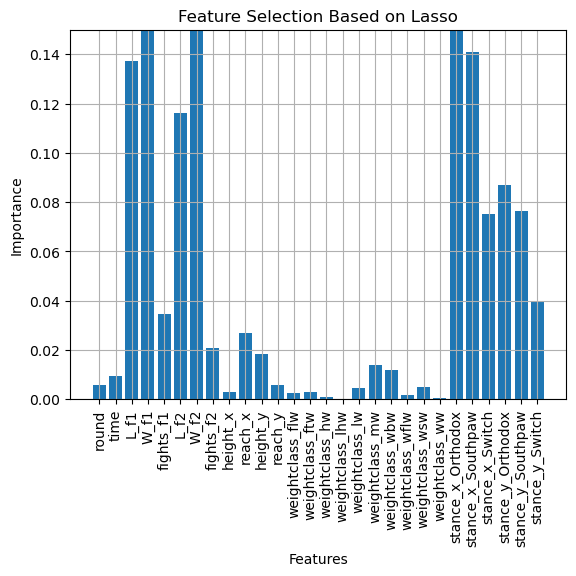

In [113]:
names=cleaned_features1.drop("outcome", axis=1).columns
lasso1 = Lasso(alpha=0.00001)
lasso1.fit(X_train, y_train)

# Using np.abs() to make coefficients positive.  
lasso1_coef = np.abs(lasso1.coef_)

# plotting the Column Names and Importance of Columns. 
plt.bar(names, lasso1_coef)
plt.xticks(rotation=90)
plt.grid()
plt.title("Feature Selection Based on Lasso")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.ylim(0, 0.15)
plt.show()

ValueError: Index data must be 1-dimensional

In [104]:
from sklearn.linear_model import LassoCV

#Lasso Cross validation
lasso_cv = LassoCV(alphas = [0.0001, 0.001,0.01, 0.1, 1, 10], random_state=0).fit(X_train, y_train)


#score
print(lasso_cv.score(X_train, y_train))
print(lasso_cv.score(X_test, y_test))

0.343345234262158
0.3491585642339754


/Users/cstone/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.58798919103566, tolerance: 0.06808510943667004
  model = cd_fast.enet_coordinate_descent_gram(
/Users/cstone/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1837383849821208, tolerance: 0.06830362396842495
  model = cd_fast.enet_coordinate_descent_gram(
